# Variational Dicke State Preparation

In [1]:
# Imports
import math
import cmath
%matplotlib inline
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from numpy import linalg as la
from scipy import linalg as sla
from scipy.special import binom
from IPython.display import clear_output
import time
import pickle
from qiskit.extensions import XGate, UnitaryGate
from qiskit import *
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
import itertools

# provider = IBMQ.load_account()
from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info.synthesis import two_qubit_cnot_decompose as two_qubit_decomp

X = np.matrix([[0,1],[1,0]],dtype=complex)
Y = np.matrix([[0,-1j],[1j,0]],dtype=complex)

swap = np.array([[1,0,0,0],
                 [0,0,1,0],
                 [0,1,0,0],
                 [0,0,0,1]])

# Local import
from DickeCircuit import DickeCirc, DickeCountParam

In [2]:
def pswap(theta):
    
    mat = np.array([[1,0,0,0],[0,np.cos(theta),-np.sin(theta),0],[0,np.sin(theta),np.cos(theta),0],[0,0,0,1]])
    
    return mat

In [3]:
def keys_fun(n,k):
    result = []
    for bits in itertools.combinations(range(n), k):
        s = ['0'] * n
        for bit in bits:
            s[bit] = '1'
        result.append(''.join(s))
    return result

In [4]:
def DickeCounts(n,k,layer,theta,shots,init):
    qc = DickeCirc(n,k,layer,theta,init)
    qc.measure(range(n),range(n))
    backend      = Aer.get_backend("qasm_simulator")
    simulate     = execute(qc, backend=backend, shots=shots)
    counts = simulate.result().get_counts()
    return counts

In [19]:
def objG(theta,constants):
    
    n = constants[0]
    k = constants[1]
    layer = constants[2]
    shots = constants[3]
    init = constants[4]
        
    keys = keys_fun(n,k)
    
    num = 5
    
    counts_dict_list = []
    for i in range(num):
        counts_dict_list.append(DickeCounts(n,k,layer,theta,shots,init))
    
    counts_avg = []
    for key in keys:
        c_list = []
        for i in range(num):
            if key in counts_dict_list[i]:
                c_list.append(counts_dict_list[i][key])
            else:
                c_list.append(0)
        counts_avg.append(np.average(c_list))

    return np.std(counts_avg)

In [20]:
def objG_state_overlap(theta,constants):
    n = constants[0]
    k = constants[1]
    layer = constants[2]
    shots = constants[3]
    init = constants[4]
       
    counts = DickeCounts(n,k,layer,theta,shots,init)
    optimal = binom(n,k)
    dotproduct = 0
    for key,value in counts.items():
        dotproduct += math.sqrt(value/shots)

    return (1 - dotproduct**2/optimal)
  

In [22]:
#prepares a Dicke state with given n and k
#returns the circuit

objf = objG_state_overlap

def Dicke(n,k,layer,shots,init):
    
    n_theta = DickeCountParam(n,k,layer)
    constants = [n,k,layer,shots,init]

    theta = []
    for i in range(n_theta):
        theta.append(np.random.uniform(0,2*np.pi))

    x_list = []
    def callback(x):
        x_list.append(objf(x,constants))
        itr = np.linspace(1,len(x_list),len(x_list))
        plt.plot(itr,x_list)
        clear_output(wait=True)
        plt.show()

    opt = sp.optimize.minimize(objf, x0=theta, args=constants, method = 'Powell', callback=callback)
    theta_min = opt.x
    print(theta_min)

    counts_best = DickeCounts(n,k,layer,theta_min,shots,init)
    print(counts_best)

    std_best = objf(theta_min,constants)
    print(std_best)

    ##simulation of the circuit with the right parameters
    return DickeCirc(n,k,layer,theta_min,init)

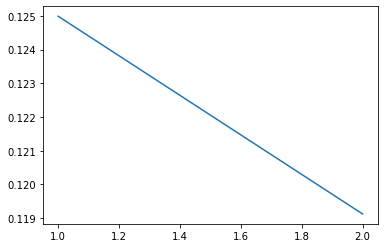

In [ ]:
n = 5
k = 2
layer = 4
shots = 3000 
init = 'pure'

qc = Dicke(n,k,layer,shots,init)
display (qc.draw(output='mpl'))
qc.measure(range(n),range(n))
backend      = Aer.get_backend("qasm_simulator")
simulate     = execute(qc, backend=backend, shots=shots)
results = simulate.result()
display (plot_histogram(results.get_counts(),figsize = (8,6),bar_labels = False))